# Week 3 - Beyond Diversification

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import edhec_risk_kit as erk
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
%matplotlib inline
%load_ext autoreload

In [3]:
%autoreload 2

## The Efficient Frontier

Why doesnt diversification help you in market crashes?

One reason is that correlations across assets increases as the market drops. Let's see if we can see this in the data.

In [4]:
ind_return = erk.get_ind_returns()  # Load and format the Ken French 30 Industry Portfolios Value Weighted Monthly Returns
ind_return.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


### Implementing a Cap-Weighted Portfolio
Most market indices are constructed by taking a set of assets and weighting them by their market equity aka market capitalization.

Let's construct a market cap weighted index from our 30 industry portfolios.

For each of these industries, we also have data on the number of stocks in each industry as well as the average market cap in each industry. Thus, we can multiply the average market cap by the number of companies to get the total market capitalization of each industry. We can then weight each industry portfolio proportional to the market capitalization of that industry.

Let's load the industry size and average number of firms:

Let's load the industry size and average number of firms (and include this in the module):
```python
def get_ind_nfirms():
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    ind = pd.read_csv("data/ind30_m_nfirms.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_size():
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    ind = pd.read_csv("data/ind30_m_size.csv", header=0, index_col=0)
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind
```

In [5]:
ind_nfirms = erk.get_ind_nfirms() # Load and format the Ken French 30 Industry Portfolios Average number of Firms
ind_nfirms.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-08,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-09,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-10,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-11,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4


In [6]:
ind_size = erk.get_ind_size() # Load and format the Ken French 30 Industry Portfolios Average size (market cap)
ind_size.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,35.98,7.12,59.72,26.41,12.02,22.27,18.36,25.52,57.59,6.18,...,350.36,13.60,56.70,35.35,66.91,1.19,46.65,10.82,18.83,24.25
1926-08,36.10,6.75,60.47,27.17,13.33,22.13,19.83,25.80,62.13,6.20,...,353.27,14.75,57.74,37.86,67.99,0.90,46.57,11.00,18.88,25.51
1926-09,37.00,8.58,64.03,27.30,14.67,21.18,19.29,26.73,65.53,6.71,...,360.96,15.05,59.61,36.82,71.02,0.95,46.11,10.94,19.67,27.21
1926-10,37.14,8.92,64.42,28.76,14.42,21.23,19.03,26.87,68.47,6.82,...,364.16,15.30,59.52,34.77,70.83,0.88,46.15,10.80,19.36,26.16
1926-11,35.88,8.62,65.08,27.38,15.79,20.14,19.03,26.54,65.06,6.84,...,363.74,14.89,58.74,32.80,68.75,0.74,45.03,10.33,18.35,23.94


In [7]:
print("ind_return.shape:",ind_return.shape)
print("ind_nfirms.shape:",ind_nfirms.shape)
print("ind_size.shape:",ind_size.shape)

ind_return.shape: (1110, 30)
ind_nfirms.shape: (1110, 30)
ind_size.shape: (1110, 30)


In [8]:
ind_mktcap = ind_nfirms * ind_size
ind_mktcap.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,1547.14,21.36,955.52,184.87,24.04,178.16,220.32,178.64,979.03,80.34,...,1751.80,40.80,396.90,212.10,4951.34,2.38,1539.45,64.92,225.96,97.00
1926-08,1552.30,20.25,967.52,190.19,26.66,177.04,237.96,180.60,1056.21,80.60,...,1766.35,44.25,404.18,227.16,5031.26,1.80,1536.81,66.00,226.56,102.04
1926-09,1591.00,25.74,1024.48,191.10,29.34,169.44,231.48,187.11,1114.01,87.23,...,1804.80,45.15,417.27,220.92,5255.48,1.90,1521.63,65.64,236.04,108.84
1926-10,1597.02,26.76,1030.72,201.32,28.84,169.84,228.36,188.09,1163.99,88.66,...,1820.80,45.90,416.64,208.62,5241.42,1.76,1522.95,64.80,232.32,104.64
1926-11,1542.84,25.86,1041.28,191.66,31.58,161.12,228.36,185.78,1106.02,88.92,...,1818.70,44.67,411.18,196.80,5087.50,1.48,1485.99,61.98,220.20,95.76


In [9]:
print("ind_mktcap.shape:",ind_mktcap.shape)

ind_mktcap.shape: (1110, 30)


Now that we have the market caps for each month, we can compute the total market capitalization over time by summing over all industries:

In [10]:
total_mktcap = ind_mktcap.sum(axis=1)
total_mktcap.head(10)

1926-07    26657.94
1926-08    27436.34
1926-09    28060.41
1926-10    28057.23
1926-11    27198.40
1926-12    27793.18
1927-01    28375.86
1927-02    28355.50
1927-03    29532.46
1927-04    29471.81
Freq: M, dtype: float64

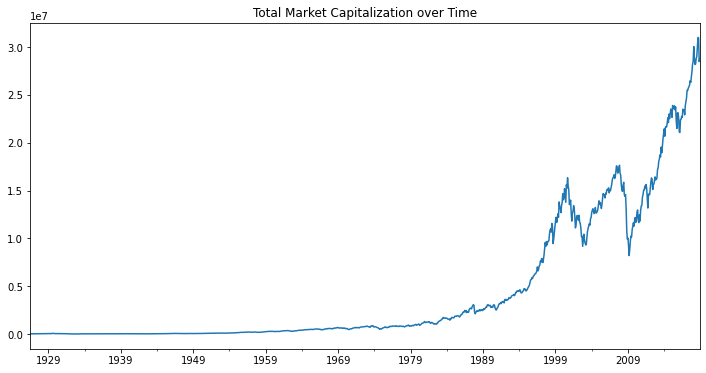

In [11]:
total_mktcap.plot(title="Total Market Capitalization over Time", figsize=(12,6))

Clearly, the market has grown over time. We have to divide each industry's market capitalization by the total market capitalization at that point in time. We can now compute the capitalization weight of each industry as follows:

In [12]:
ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
ind_capweight.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.058037,0.000801,0.035844,0.006935,0.000902,0.006683,0.008265,0.006701,0.036726,0.003014,...,0.065714,0.001531,0.014889,0.007956,0.185736,0.000089,0.057748,0.002435,0.008476,0.003639
1926-08,0.056578,0.000738,0.035264,0.006932,0.000972,0.006453,0.008673,0.006583,0.038497,0.002938,...,0.064380,0.001613,0.014732,0.008280,0.183379,0.000066,0.056014,0.002406,0.008258,0.003719
1926-09,0.056699,0.000917,0.036510,0.006810,0.001046,0.006038,0.008249,0.006668,0.039700,0.003109,...,0.064318,0.001609,0.014870,0.007873,0.187292,0.000068,0.054227,0.002339,0.008412,0.003879
1926-10,0.056920,0.000954,0.036736,0.007175,0.001028,0.006053,0.008139,0.006704,0.041486,0.003160,...,0.064896,0.001636,0.014850,0.007436,0.186812,0.000063,0.054280,0.002310,0.008280,0.003730
1926-11,0.056725,0.000951,0.038285,0.007047,0.001161,0.005924,0.008396,0.006831,0.040665,0.003269,...,0.066868,0.001642,0.015118,0.007236,0.187051,0.000054,0.054635,0.002279,0.008096,0.003521


The way to interpret this is, in July of 1926, food was 0.058, that means 5.8% of the total market capitalization.

In [13]:
# Fast check:
ind_capweight["1926"].sum(axis="columns") # Sum all columns in 1926 for each month. 

1926-07    1.0
1926-08    1.0
1926-09    1.0
1926-10    1.0
1926-11    1.0
1926-12    1.0
Freq: M, dtype: float64

Let's verify that the sum of the cap weights of all the columns should always sum to 1. Because these are floating point numbers, it is not a good idea to test if they sum to 1 by using == 1.0. Instead, we make sure they are very close to 1 as follows.

In [14]:
all(abs(ind_capweight.sum(axis="columns") - 1) < 1E-10)

True

Let's look at the fraction of the market occupied by the Steel industry over time and compare it with the Finance industry.

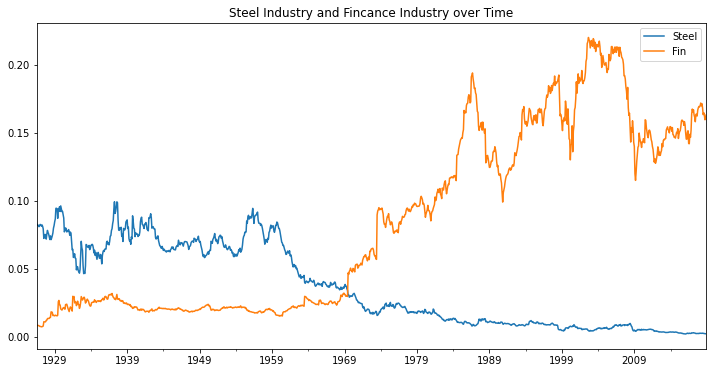

In [15]:
ind_capweight[["Steel", "Fin"]].plot(title="Steel Industry and Fincance Industry over Time", figsize=(12,6))

### Constructing a Cap Weighted Market Index
One way to construct a market index is to build a portfolio whose weights are rebalanced back to the target weights every period. In reality, the weights may drift over time but this simplification is close enough.

In [16]:
# The total Market return is nothing more than the weighted average of each one of these industries.
total_market_return = (ind_capweight * ind_return).sum(axis="columns")

total_market_return.head()

1926-07    0.031375
1926-08    0.028957
1926-09    0.005566
1926-10   -0.028504
1926-11    0.028039
Freq: M, dtype: float64

So, over time all we're doing is, you're just computing the weighted average return of each industry.

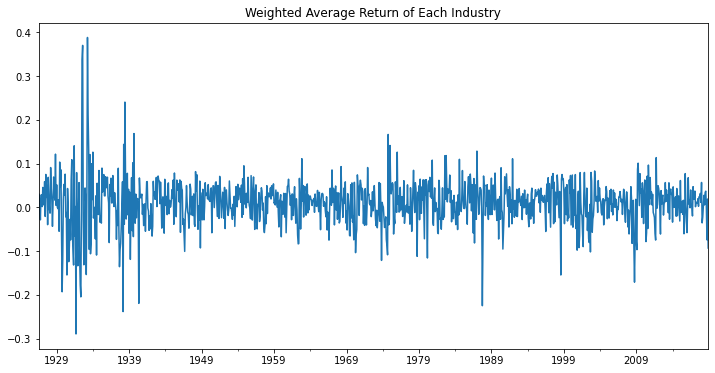

In [17]:
total_market_return.plot(title="Weighted Average Return of Each Industry", figsize=(12,6))

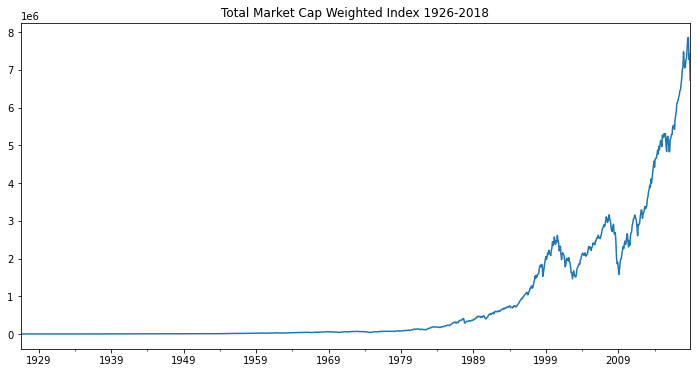

In [18]:
total_market_index = erk.drawdown(total_market_return).Wealth

total_market_index.plot(title="Total Market Cap Weighted Index 1926-2018", figsize=(12,6))

Putting it all together we have:
```python
def get_total_market_index_returns():
    """
    Load the 30 industry portfolio data and derive the returns of a capweighted total market index
    """
    ind_nfirms = get_ind_nfirms()
    ind_size = get_ind_size()
    ind_return = get_ind_returns()
    ind_mktcap = ind_nfirms * ind_size
    total_mktcap = ind_mktcap.sum(axis=1)
    ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
    total_market_return = (ind_capweight * ind_return).sum(axis="columns")
    
    return total_market_return
```

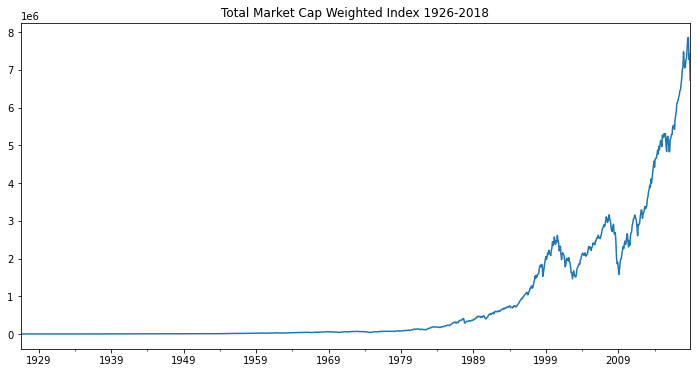

In [19]:
# By Module:
total_market_return = erk.get_total_market_index_returns()
total_market_index = erk.drawdown(total_market_return).Wealth
total_market_index.plot(title="Total Market Cap Weighted Index 1926-2018", figsize=(12,6))

### Rolling Windows
Let's construct a rolling window of returns over a trailing 36 month period. Pandas contains direct support for rolling windows, and allows you to aggregate the returns over a window. In our case, lets compute the average return over a trailing 36 month window.

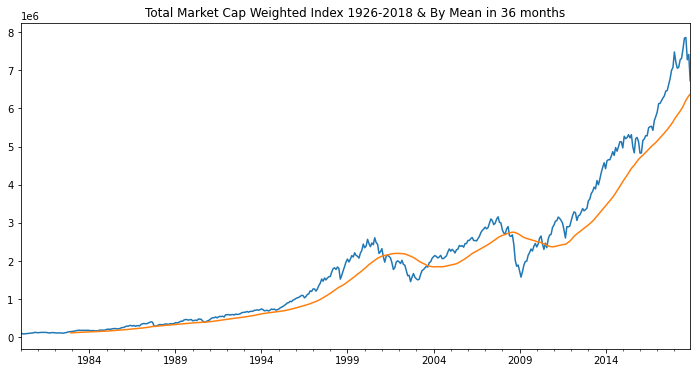

In [20]:
total_market_index["1980":].plot(title="Total Market Cap Weighted Index 1926-2018 & By Mean in 36 months", figsize=(12, 6))
total_market_index["1980":].rolling(window=36).mean().plot()

We dont really want the mean return, we want to look at the trailing 3 year compounded return. We need to apply our own function, instead of mean().

Each time the window is advanced, a new DataFrame (with just the slice of the DataFrame in the window) is used to generate a new value. You can either use one of the built-in DataFrame methods like .mean or you can use the .aggregate method to apply your own function to each column for all the rows that fall in that window.

Let's create a time series of the annualized returns over the trailing 36 months and the average correlation across stocks over that same 36 months.

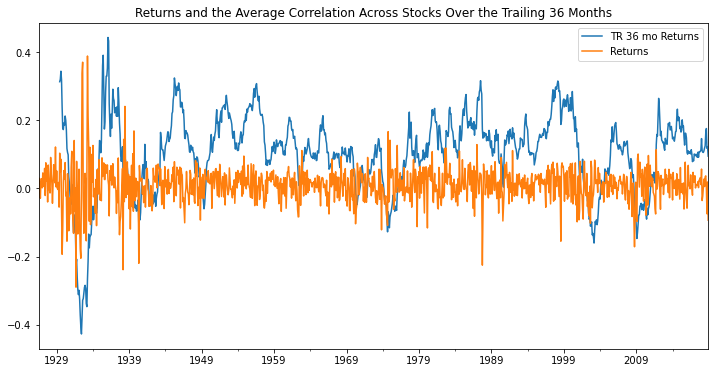

In [21]:
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(erk.annualize_rets, periods_per_year=12)

tmi_tr36rets.plot(title="Returns and the Average Correlation Across Stocks Over the Trailing 36 Months",figsize=(12,6), label="TR 36 mo Returns", legend=True)
total_market_return.plot(label="Returns", legend=True)

### Rolling Correlations: Multi Indexes and .groupby
Next we want to look at average correlations between all the industries over that same trailing 3 year window.

Let's start by contructing the time series of correlations over time over a 36 month window.

In [22]:
ts_corr = ind_return.rolling(window=36).corr()
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
2018-12 Whlsl  0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail  0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals  0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin    0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other  0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                  Clths      Hlth     Chems     Txtls  ...     Telcm  \
2018-12 Whlsl  0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail  0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals  0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin    0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other  0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                  Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
2018-12 Whlsl  0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail  0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals  0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin    0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other  0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                  Meals       Fin     Other  
2018-12 Whlsl  0.643879  0.746480  0.767652  
        Rtail  0.616947  0.611883  0.619918  
        Meals  1.000000  0.502563  0.605226  
        Fin    0.502563  1.000000  0.734837  
        Other  0.605226  0.734837  1.000000  

[5 rows x 30 columns]

A multi-index table. The first index is a date, and then the second index is the industry, and the columns are the industries. So what that's saying is, for this date, wholesale and food had a correlation of 0.475. At this date, retail and beer had a correlation of 0.406. At this date, so on and so forth, finance and healthcare had a correlation of 0.658, etc. 

We can make this easier to see if we give names to the levels of the index:

In [23]:
ts_corr.index.names

FrozenList([None, None])

In [24]:
ts_corr.index.names = ['date', 'industry']
ts_corr.index.names

FrozenList(['date', 'industry'])

In [25]:
ts_corr.tail()

Food      Beer     Smoke     Games     Books     Hshld  \
date    industry                                                               
2018-12 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail     0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals     0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin       0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other     0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                     Clths      Hlth     Chems     Txtls  ...     Telcm  \
date    industry                                          ...             
2018-12 Whlsl     0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail     0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals     0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin       0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other     0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                     Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
date    industry                                                               
2018-12 Whlsl     0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail     0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals     0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin       0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other     0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                     Meals       Fin     Other  
date    industry                                
2018-12 Whlsl     0.643879  0.746480  0.767652  
        Rtail     0.616947  0.611883  0.619918  
        Meals     1.000000  0.502563  0.605226  
        Fin       0.502563  1.000000  0.734837  
        Other     0.605226  0.734837  1.000000  

[5 rows x 30 columns]

To compute the rolling correlations, we need to group all the rows for the same date, and then compute the average across all the entries in the dataframe.

We need to compute the mean of all the values of the dataframe, not the mean of each column. We could compute the means of the means, but it's simpler to just call our own function on the correlation matrix.

Although we could construct a function to compute this, it's often easier to provide a lambda function which is a simple one-time-use function and therefore has no name. In every other way, it's a standard pandas function.

We do so as follows:

In [26]:
# We want a kind of a correlation matrix as the input. So let's apply this lambda function, 
# it's going to be called with all the rows for that date and all the columns for that date. 
# The entries here are correlations. We want the mean correlation.

ind_tr36corr = ts_corr.groupby(level='date').apply(lambda cormat: cormat.values.mean())
ind_tr36corr.tail()

date
2018-08    0.416673
2018-09    0.401186
2018-10    0.409397
2018-11    0.403975
2018-12    0.479502
Freq: M, dtype: float64

Now, we can plot the trailing 36 month returns against the average correlations in the trailing 36 months.

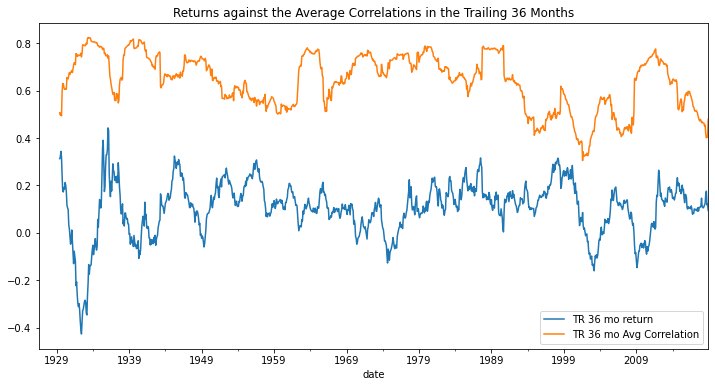

In [27]:
tmi_tr36rets.plot(title="Returns against the Average Correlations in the Trailing 36 Months", legend=True, label="TR 36 mo return", figsize=(12,6))
ind_tr36corr.plot(legend=True, label="TR 36 mo Avg Correlation")

With a secundary Y axis:

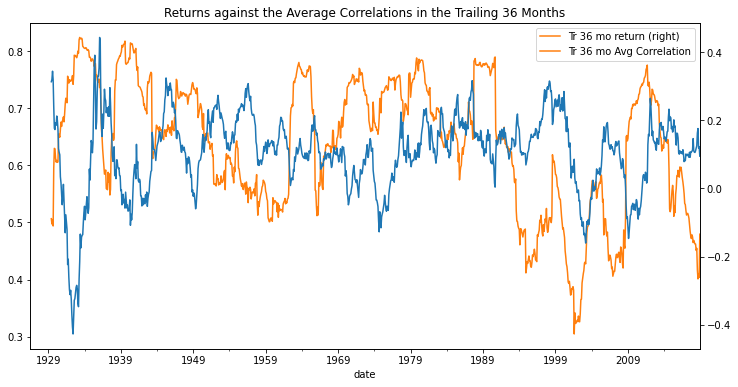

In [28]:
tmi_tr36rets.plot(title="Returns against the Average Correlations in the Trailing 36 Months", secondary_y=True, legend=True, label="Tr 36 mo return", figsize=(12,6))
ind_tr36corr.plot(legend=True, label="Tr 36 mo Avg Correlation")

Clearly, these two series are negatively correlated, which explains why diversification fails you when you need it most. When markets fall, correlations rise, making diversification much less valuable. Let's make a Zoom at 2007 onwards.

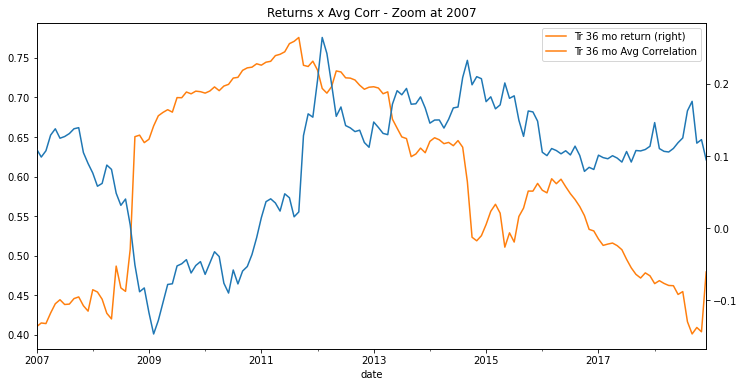

In [29]:
tmi_tr36rets["2007":].plot(title="Returns x Avg Corr - Zoom at 2007", secondary_y=True, legend=True, label="Tr 36 mo return", figsize=(12,6))
ind_tr36corr["2007":].plot(legend=True, label="Tr 36 mo Avg Correlation")

Diversification is not going to help you. So let's try and put a number to that. Let's take the correlation between these two series. I will compute the correlation between the trailing returns and the trailing correlations.

In [30]:
# Correlation between the "average correlation of industries" and "returns".
tmi_tr36rets.corr(ind_tr36corr)

-0.2801006506288413

It's actually negative. And that is really the problem with diversification. **Diversification does not help you when markets are crashing.**

Instead, we'll look at how to use Insurance to protect the downside.

## Implementing Portfolio Insurance (CPPI) and Drawdown Constraints
We'll start by implementing the basic Constant Proportion Portfolio Insurance dynamic risk budgeting algorithm, and test it against different portfolios.

In [31]:
# Load the industry returns and the total market index we previously created
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [32]:
# Risk Asset:
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
risky_r.head()

,Steel,Fin,Beer
2000-01,-0.0277,-0.0442,-0.0228
2000-02,0.0684,-0.0849,-0.1164
2000-03,0.0349,0.1669,0.0013
2000-04,-0.0084,-0.0425,0.0368
2000-05,-0.0492,0.0506,0.1187


In [33]:
risky_r.shape

(228, 3)

In [34]:
# Assume the safe asset is paying 3% per year

safe_r = pd.DataFrame().reindex_like(risky_r)  #Create a Data with the same shape as risky_r
safe_r.values[:] = 0.03/12                     # fast way to set all values to a number ~ 3%/year
start = 1000                                   # start at $1000
floor = 0.80                                   # set the floor to 80 percent of the starting value

Now, we need to backtest this strategy by starting at the beginning and at every point in time:

    1.Cushion  - (Asset Value - Floor Value)
    2.Compute a Allocation to Safe and Risk Assets -> Risk Budget
    3.Recompute the Asset Value based on Returns
Although we rarely use for-loops in working with time-series, relying instead of Pandas and Numpy to do the looping internally (and efficiently) this is easier to do with a traditional for-loop.

### An Aside on Efficiency
Although For-Loops are common, we've almost never used them so far. That is not an accident. For-Loops in python are expensive, and we have so far relied on numpy to do the looping for us efficiently in C. The problem is that it's easy to miss the fact that there is a loop here.

For instance, consider two implementations of the function to compound returns.

In [35]:
def compound1(r):
    return (r+1).prod()-1

def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [36]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [37]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

They both produce the same result, but are they identical? The second one might appear a bit more clear to some programmers, which of these is more efficient? We can find out by using the %timeit magic.  It takes a little time because it's actually going to run it not just once, it's going to run it several times, and it's going to compute the average time that it takes to run that command. 

In [38]:
%timeit compound1(risky_r)

1.7 ms ± 74.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
%timeit compound2(risky_r)

1.55 ms ± 68.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Let's add this to our toolkit, which we'll use later:
```python
def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())
```

### Back to CPPI

In [40]:
# Set up the CPPI parameters
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3

In [41]:
# Set up some DataFrames for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)

In [42]:
for step in range(n_steps):  # 0 to (n_steps -1)
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)   # don't go above a 100 percent 
    risky_w = np.maximum(risky_w, 0)   # don't go below zero percent
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # recompute the new account value at the end of this step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step]) # see *1
    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()

*1 - Let's say you have 700 dollars in `risky_alloc` and 300 dollars in `safe_alloc`, then you take 700 dollars and you multiply that by the return for that month for that timestep of the risky asset, and then you have 300 dollars in the safe asset so you multiply that by the safe return for that timestep.

In [43]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


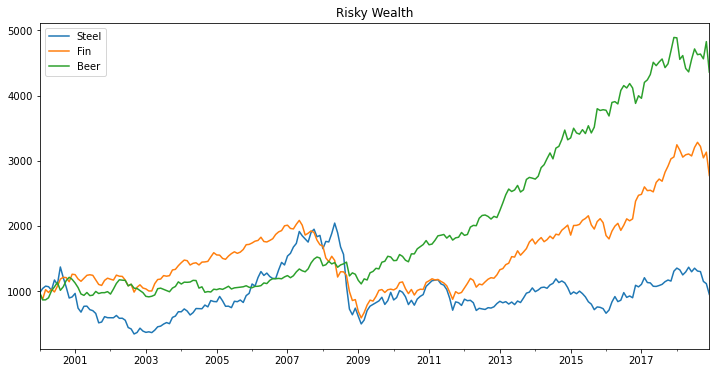

In [44]:
risky_wealth.plot(title="Risky Wealth", figsize=(12,6))

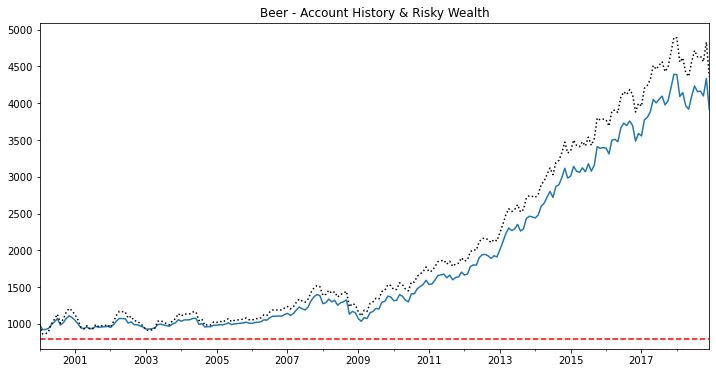

In [45]:
ind = "Beer"
ax = account_history[ind].plot(title="Beer - Account History & Risky Wealth", figsize=(12,6))
risky_wealth[ind].plot(style="k:")  # black & white
ax.axhline(y=floor_value, color='r', linestyle='--') # floor value

So let's look at the risky with history, and see how these weights varied over time.

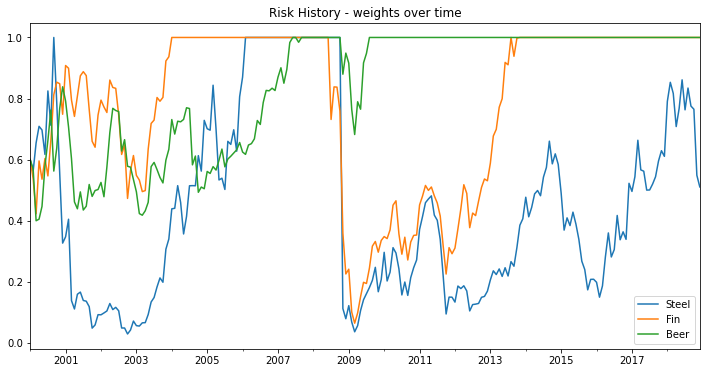

In [46]:
risky_w_history.plot(title="Risk History - weights over time", figsize=(12,6))

### Compare Beer - Risk History x Account History & Risky Wealth

Let's plot again "Beer - Account History & Risky Wealth" to compare:

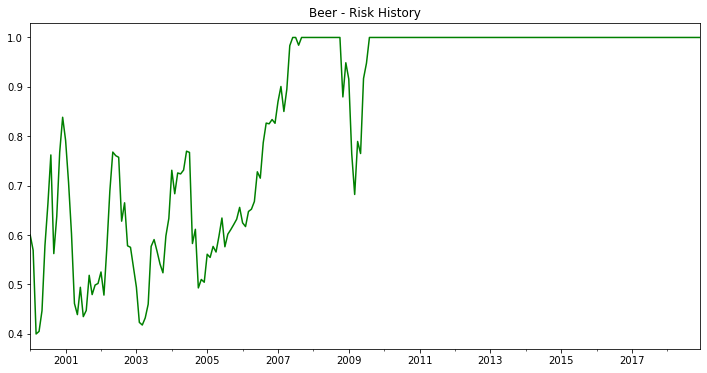

In [47]:
risky_w_history["Beer"].plot(color="green",title="Beer - Risk History", figsize=(12,6))

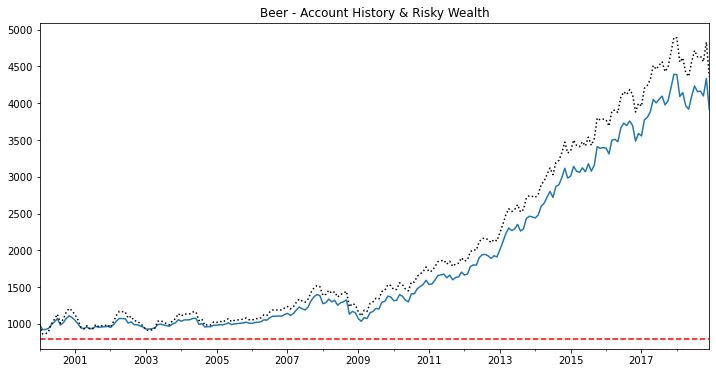

In [48]:
ind = "Beer"
ax = account_history[ind].plot(title="Beer - Account History & Risky Wealth", figsize=(12,6))
risky_wealth[ind].plot(style="k:")  # black & white
ax.axhline(y=floor_value, color='r', linestyle='--') # floor value

In the case of beer, you started somewhere in the middle and there was a lot of variation. So that means we did have allocations. So eventually, it ended up with 100 percent allocation to the risky asset. So at some point in time, it just becomes, grows along with the risky asset. It grows. You can see the correlation between them is almost what? 

The correlation is 100 percent because at some point in time, the blue line is just getting exactly the same returns as that dotted line. But over the early days, you can see that the variation in the blue line is less than the variation in the dotted line and that's because some of the allocation is to the safe asset at that time. 

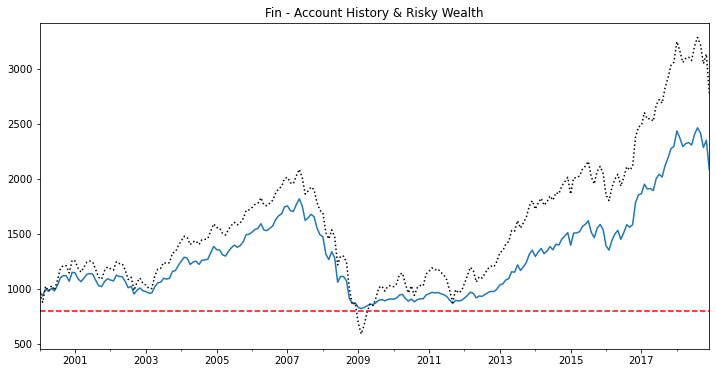

In [49]:
ind = "Fin"
ax = account_history[ind].plot(title="Fin - Account History & Risky Wealth", figsize=(12,6))
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

Well, you can see here CPPI has been far more important and far more effective because in the beginning g, everything was alright, finance was doing really well, you weren't getting all of the benefits so your blue line was below the dotted line. Then in 2008, finance just crashed. If you had been invested in finance, you would have ended up piercing your floor. Think about somebody who wants to either retire at that point in time or who has a kid who wants to go to college at that point in time, that would have been brutal. Instead, what you can see here is the blue line is very nicely deftly bouncing off this. That's because there was no violation of the floor in 2009, because there was so little risk budget at that point. Now, the disadvantage of that of course is when it bounces back, you only have a small exposure to that portfolio and as a result, you don't enjoy all the upside.

### Steel Case - How CPPI protected you from breaching your floor

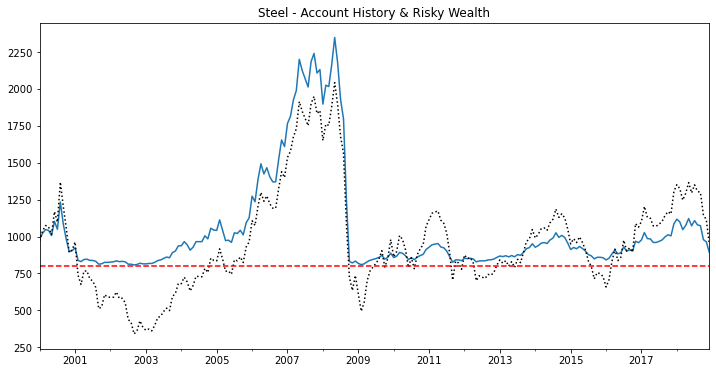

In [50]:
ind = "Steel"
ax = account_history[ind].plot(title="Steel - Account History & Risky Wealth", figsize=(12,6))
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

It's even more dramatic because the steel industry just tanked right away, in 2000-2003. If you had been invested in the steel industry, oh my God, that would have been brutal, that would've been completely brutal. You can see that CPPI there is really bailing you out and for most of the life of that thing, CPPI is by far the place you want to be. It's far less volatile and it protects you from breaching your floor. 

Let's put this all into a new function which we can add to our edhec_risk_kit.py:
```python
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor

    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # fast way to set all values to a number
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r
    }
    return backtest_result
```

And while we're at it, let's also write a convenience function to provide summary statistics on a set of returns:
```python
def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })
```

Let's test it:

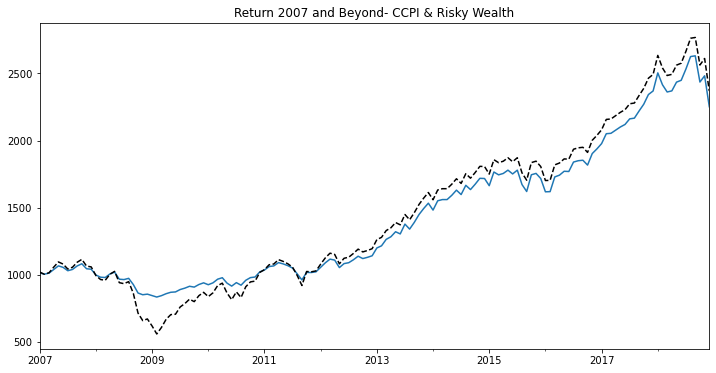

In [51]:
btr = erk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(title="Return 2007 and Beyond- CCPI & Risky Wealth",legend=False, figsize=(12, 6))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

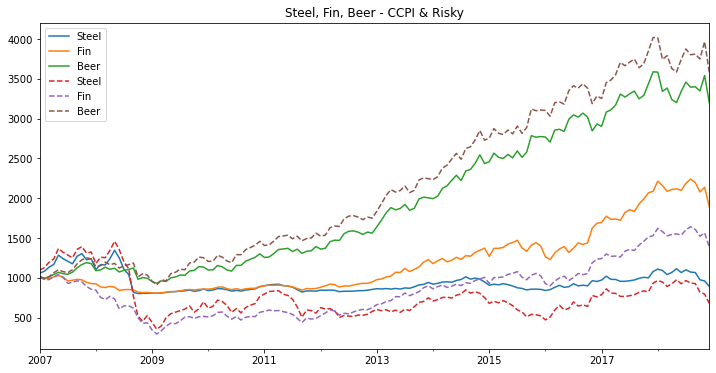

In [52]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]])
ax = btr["Wealth"].plot(title="Steel, Fin, Beer - CCPI & Risky",figsize=(12,6))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [53]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [54]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.014490,0.126906,-1.554266,11.668243,0.068652,0.098467,-0.341351,-0.404132
Fin,0.054690,0.109579,-0.254976,5.589082,0.047503,0.068951,0.219159,-0.216868
Beer,0.101518,0.114363,-0.743585,4.527865,0.051074,0.069081,0.608531,-0.217280


In [55]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


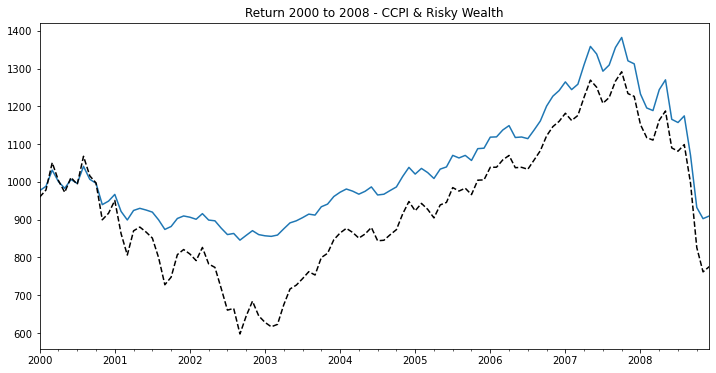

In [56]:
btr = erk.run_cppi(tmi_return["2000":"2008"])
ax = btr["Wealth"].plot(title="Return 2000 to 2008 - CCPI & Risky Wealth",legend=False, figsize=(12, 6))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

Insurance strategies usually help with drawdowns, but they can also be adapted to explictly limit the drawdown.

### Explicitly Limiting Drawdowns
Modify the code to adjust the floor if needed, based on an additional new parameter drawdown.
```python
if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
```
You can now call run_cppi witk a parameter drawdown. For instance, to run CPPI and limit the drawdown to 25%

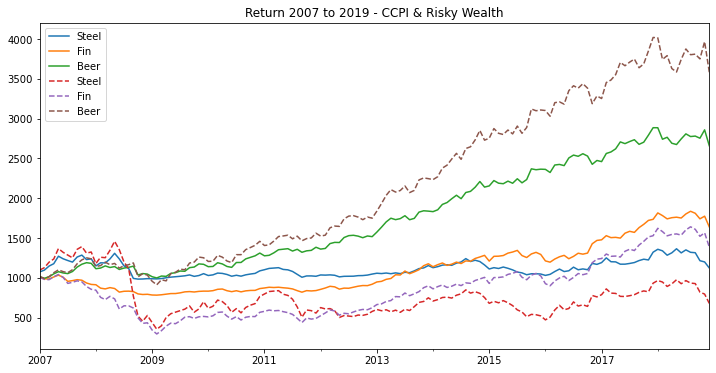

In [57]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)
ax = btr["Wealth"].plot(title="Return 2007 to 2019 - CCPI & Risky Wealth", figsize=(12, 6))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [58]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.262958,-0.248059
Fin,0.041975,0.085028,0.136964,-0.243626
Beer,0.084375,0.086263,0.613413,-0.161186


In [59]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.012370,-0.718465
Beer,0.111554,0.127971,0.620132,-0.271368


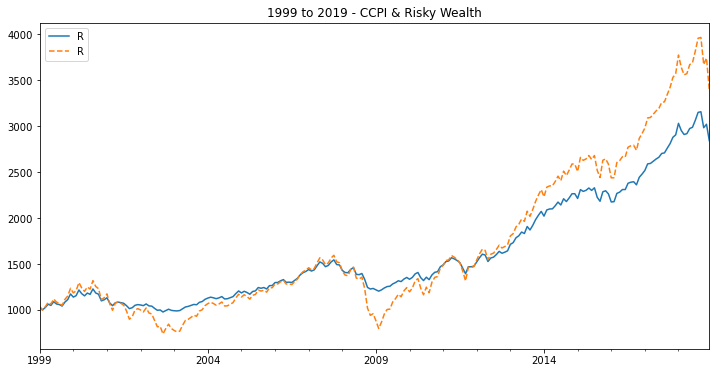

In [60]:
btr = erk.run_cppi(tmi_return["1999":], drawdown=0.25)
ax = btr["Wealth"].plot(title="1999 to 2019 - CCPI & Risky Wealth", figsize=(12, 6))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [61]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
R,0.052391,0.078951,0.275935,-0.220824


In [62]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", 
                                                              "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
R,0.06137,0.148571,0.205314,-0.499943
